In [3]:
import pandas as pd
import numpy as np

# Load CSVs
accident_df = pd.read_csv("accidents_2015_to_2023.csv")
vehicle_df = pd.read_csv("vehicle_2015_to_2023.csv")
person_df = pd.read_csv("person_2015_to_2023.csv")

# Drop duplicates and invalid crash records
for df in [accident_df, vehicle_df, person_df]:
    df.drop_duplicates(inplace=True)
    df.dropna(subset=["ST_CASE"], inplace=True)

# VEHICLE aggregation to crash level
vehicle_agg = vehicle_df.groupby("ST_CASE").agg({
    "VE_FORMS": "nunique",          # Number of vehicle types/forms
    "TRAV_SP": "mean",              # Avg travel speed
    "ROLLOVER": "sum",              # Number of rollovers
    "FIRE_EXP": "sum"               # Number of fires
}).reset_index().rename(columns={
    "VE_FORMS": "vehicle_forms_count",
    "TRAV_SP": "avg_travel_speed",
    "ROLLOVER": "num_rollovers",
    "FIRE_EXP": "num_fires"
})

# PERSON aggregation to crash level
person_agg = person_df.groupby("ST_CASE").agg({
    "AGE": ["mean", "min", "max"],
    "SEX": lambda x: (x == 1).sum(),        # Number of males
    "INJ_SEV": lambda x: (x == 4).sum(),    # Fatal injuries
    "DRINKING": lambda x: (x == 1).sum()    # Alcohol involvement
})
person_agg.columns = ["avg_age", "min_age", "max_age", "num_males", "num_fatalities", "num_drinking"]
person_agg = person_agg.reset_index()

# Merge all into a single crash-level dataset
merged_df = accident_df.merge(vehicle_agg, on="ST_CASE", how="left") \
                       .merge(person_agg, on="ST_CASE", how="left")

# Create binary target column: fatal crash or not
merged_df["num_fatalities"] = merged_df["num_fatalities"].fillna(0).astype(int)
merged_df["fatal_crash"] = (merged_df["num_fatalities"] > 0).astype(int)

# Final output
print("Unified dataset shape:", merged_df.shape)
merged_df.head()


<ipython-input-3-b3f4c5ab8379>:5: DtypeWarning: Columns (38,40,60,62,82,84,86,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_df = pd.read_csv("accidents_2015_to_2023.csv")
<ipython-input-3-b3f4c5ab8379>:6: DtypeWarning: Columns (6,14,56,58,61,85,99,101,129,147,149,151,153,183,188,189,190,191,192,193,195,197,199,201,203,205,207,209,211,213,215,217,219,221) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle_df = pd.read_csv("vehicle_2015_to_2023.csv")
<ipython-input-3-b3f4c5ab8379>:7: DtypeWarning: Columns (15,28,70,80,84,86,88,90,92,94,110,116,118,120,126,130,132,134,136,138,140,142,144,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  person_df = pd.read_csv("person_2015_to_2023.csv")


Unified dataset shape: (322048, 103)


,STATE,STATENAME,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERSONS,PERMVIT,PERNOTMVIT,...,avg_travel_speed,num_rollovers,num_fires,avg_age,min_age,max_age,num_males,num_fatalities,num_drinking,fatal_crash
0,1.0,Alabama,10001,1,1,0,0,1,1,0,...,376.750000,9,0,38.000000,3,68,10,12,2,1
1,1.0,Alabama,10002,1,1,0,0,1,1,0,...,537.357143,15,1,39.363636,18,66,12,12,2,1
2,1.0,Alabama,10003,1,1,0,0,2,2,0,...,251.466667,1,2,31.550000,18,64,14,9,1,1
3,1.0,Alabama,10004,1,1,0,0,1,1,0,...,380.777778,3,0,34.882353,17,80,13,9,3,1
4,1.0,Alabama,10005,2,2,0,0,2,2,0,...,292.416667,4,0,90.736842,13,999,12,9,1,1


In [4]:
# Display all column names containing relevant weather, location, and coordinate information
relevant_keywords = ['LAT', 'LONG', 'WEATHER', 'CITY', 'STATE', 'ROUTE', 'ROAD', 'MILEPT','TWAY_ID', 'LOC','LGT_CONDNAME','TRAFFIC', 'HARM']
columns_of_interest = [col for col in merged_df.columns if any(keyword in col.upper() for keyword in relevant_keywords)]

# Filter out the relevant columns + fatal_crash label for weather-location-based analysis
weather_location_df = merged_df[['ST_CASE'] + columns_of_interest + ['fatal_crash']]
weather_location_df.head()

,ST_CASE,STATE,STATENAME,CITY,ROUTE,ROUTENAME,TWAY_ID,TWAY_ID2,MILEPT,MILEPTNAME,...,LGT_CONDNAME,WEATHER1,WEATHER1NAME,WEATHER2,WEATHER2NAME,WEATHER,WEATHERNAME,CITYNAME,ï»¿STATE,fatal_crash
0,10001,1.0,Alabama,0,3,State Highway,SR-5,NaN,1754,1754,...,Dark - Not Lighted,1.0,Clear,0.0,No Additional Atmospheric Conditions,1,Clear,NaN,NaN,1
1,10002,1.0,Alabama,0,1,Interstate,I-65,NaN,3604,3604,...,Dark - Not Lighted,10.0,Cloudy,0.0,No Additional Atmospheric Conditions,10,Cloudy,NaN,NaN,1
2,10003,1.0,Alabama,0,2,U.S. Highway,US-SR 6,NaN,1958,1958,...,Dark - Not Lighted,1.0,Clear,0.0,No Additional Atmospheric Conditions,1,Clear,NaN,NaN,1
3,10004,1.0,Alabama,0,3,State Highway,SR-27,NaN,566,566,...,Dark - Not Lighted,10.0,Cloudy,0.0,No Additional Atmospheric Conditions,10,Cloudy,NaN,NaN,1
4,10005,1.0,Alabama,2050,2,U.S. Highway,US-SR 53,HINTON WATERS AVE,308,308,...,Daylight,1.0,Clear,0.0,No Additional Atmospheric Conditions,1,Clear,NaN,NaN,1


In [6]:
final_columns = [
    'ST_CASE',
    'STATENAME',
    'CITYNAME',
    'ROUTE',
    'MILEPT',
    'LATITUDE',
    'LONGITUD',
    'HARM_EVNAME',
    'REL_ROADNAME',
    'TWAY_ID',
    'WEATHERNAME',
    'LGT_CONDNAME',
    'fatal_crash'
]

# Create cleaned DataFrame
final_weather_location_df = merged_df[final_columns]
final_weather_location_df.head()

,ST_CASE,STATENAME,CITYNAME,ROUTE,MILEPT,LATITUDE,LONGITUD,HARM_EVNAME,REL_ROADNAME,TWAY_ID,WEATHERNAME,LGT_CONDNAME,fatal_crash
0,10001,Alabama,NaN,3,1754,33.878653,-87.325328,Embankment,On Roadside,SR-5,Clear,Dark - Not Lighted,1
1,10002,Alabama,NaN,1,3604,34.910442,-86.908708,Ditch,On Median,I-65,Cloudy,Dark - Not Lighted,1
2,10003,Alabama,NaN,2,1958,32.142006,-85.758456,Tree (Standing Only),On Roadside,US-SR 6,Clear,Dark - Not Lighted,1
3,10004,Alabama,NaN,3,566,31.439814,-85.510300,Mail Box,On Roadside,SR-27,Cloudy,Dark - Not Lighted,1
4,10005,Alabama,NaN,2,308,31.319331,-85.515100,Motor Vehicle In-Transport,On Roadway,US-SR 53,Clear,Daylight,1


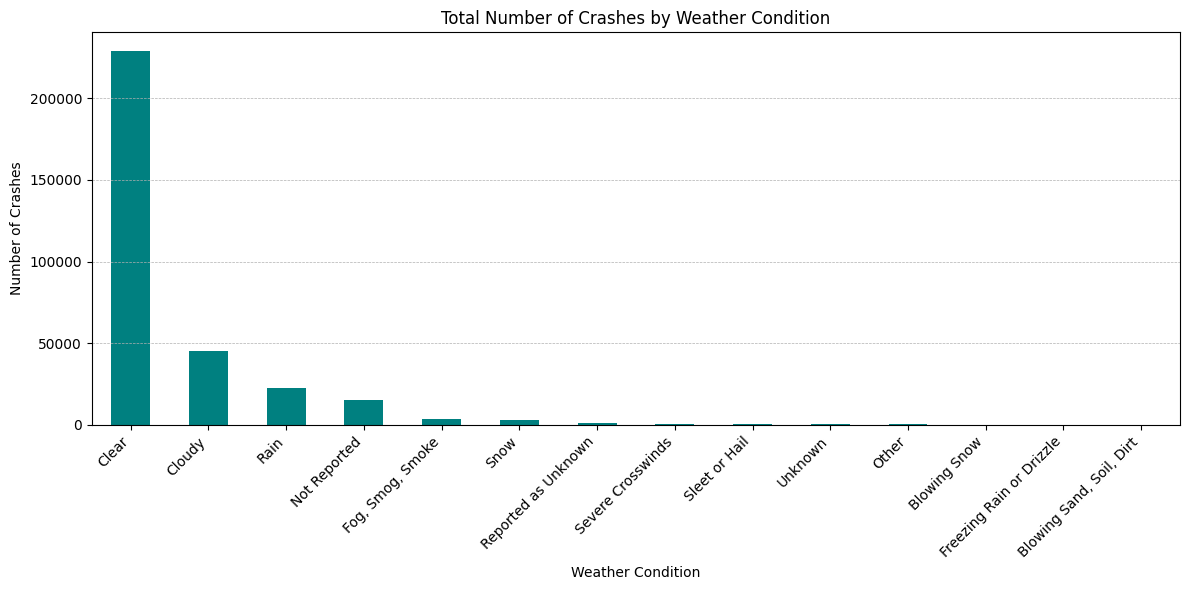

In [8]:
import matplotlib.pyplot as plt
accident_counts = final_weather_location_df["WEATHERNAME"].value_counts().sort_values(ascending=False)

# Plot the total number of crashes by weather condition
plt.figure(figsize=(12, 6))
accident_counts.plot(kind="bar", color="teal")
plt.title("Total Number of Crashes by Weather Condition")
plt.ylabel("Number of Crashes")
plt.xlabel("Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

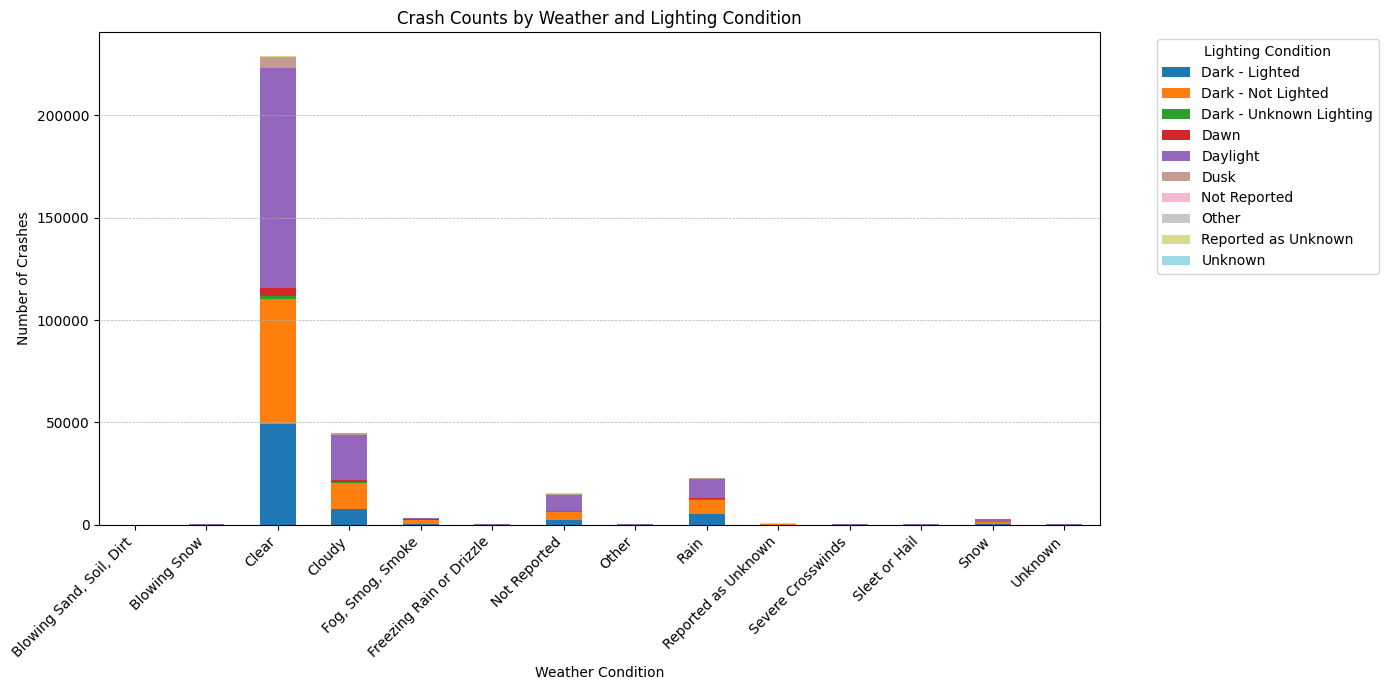

In [10]:
grouped = (
    final_weather_location_df
    .groupby(["WEATHERNAME", "LGT_CONDNAME"])
    .size()
    .unstack(fill_value=0)
)

# Plot as a stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title("Crash Counts by Weather and Lighting Condition")
plt.ylabel("Number of Crashes")
plt.xlabel("Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Lighting Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [16]:
from sklearn.cluster import DBSCAN

lat_long_df = final_weather_location_df[['LATITUDE', 'LONGITUD']].dropna()
lat_long_df = lat_long_df[(lat_long_df["LATITUDE"] != 0) & (lat_long_df["LONGITUD"] != 0)].drop_duplicates()

# Convert coordinates to radians for haversine distance
coords_rad = np.radians(lat_long_df[['LATITUDE', 'LONGITUD']].values)

# DBSCAN clustering setup (10 km radius)
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian

# Apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')
lat_long_df['Cluster_Label'] = db.fit_predict(coords_rad)
lat_long_df.head()


,LATITUDE,LONGITUD,Cluster_Label
0,33.878653,-87.325328,-1
1,34.910442,-86.908708,-1
2,32.142006,-85.758456,-1
3,31.439814,-85.510300,-1
4,31.319331,-85.515100,-1


In [17]:
# Count number of clusters
num_clusters = len(set(lat_long_df['Cluster_Label'])) - (1 if -1 in lat_long_df['Cluster_Label'].values else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 1648


In [18]:
final_df = final_weather_location_df.merge(
    lat_long_df[['LATITUDE', 'LONGITUD', 'Cluster_Label']],
    on=['LATITUDE', 'LONGITUD'],
    how='left'
)

# Filter the desired columns for the final output
final_columns = [
    'ST_CASE',
    'STATENAME',
    'CITYNAME',
    'ROUTE',
    'MILEPT',
    'LATITUDE',
    'LONGITUD',
    'HARM_EVNAME',
    'REL_ROADNAME',
    'TWAY_ID',
    'WEATHERNAME',
    'LGT_CONDNAME',
    'Cluster_Label'
]

final_df = final_df[final_columns]
final_df.head()

,ST_CASE,STATENAME,CITYNAME,ROUTE,MILEPT,LATITUDE,LONGITUD,HARM_EVNAME,REL_ROADNAME,TWAY_ID,WEATHERNAME,LGT_CONDNAME,Cluster_Label
0,10001,Alabama,NaN,3,1754,33.878653,-87.325328,Embankment,On Roadside,SR-5,Clear,Dark - Not Lighted,-1
1,10002,Alabama,NaN,1,3604,34.910442,-86.908708,Ditch,On Median,I-65,Cloudy,Dark - Not Lighted,-1
2,10003,Alabama,NaN,2,1958,32.142006,-85.758456,Tree (Standing Only),On Roadside,US-SR 6,Clear,Dark - Not Lighted,-1
3,10004,Alabama,NaN,3,566,31.439814,-85.510300,Mail Box,On Roadside,SR-27,Cloudy,Dark - Not Lighted,-1
4,10005,Alabama,NaN,2,308,31.319331,-85.515100,Motor Vehicle In-Transport,On Roadway,US-SR 53,Clear,Daylight,-1


In [21]:
final_df['Cluster_Label'].value_counts()

,count
Cluster_Label,
-1,267651
39,1884
11,1485
210,1390
522,1109
...,...
534,4
1371,4
959,2


In [26]:
final_df.to_csv('/content/accident_clusters.csv', index=False)
final_df.head()

,ST_CASE,STATENAME,CITYNAME,ROUTE,MILEPT,LATITUDE,LONGITUD,HARM_EVNAME,REL_ROADNAME,TWAY_ID,WEATHERNAME,LGT_CONDNAME,Cluster_Label
0,10001,Alabama,NaN,3,1754,33.878653,-87.325328,Embankment,On Roadside,SR-5,Clear,Dark - Not Lighted,-1
1,10002,Alabama,NaN,1,3604,34.910442,-86.908708,Ditch,On Median,I-65,Cloudy,Dark - Not Lighted,-1
2,10003,Alabama,NaN,2,1958,32.142006,-85.758456,Tree (Standing Only),On Roadside,US-SR 6,Clear,Dark - Not Lighted,-1
3,10004,Alabama,NaN,3,566,31.439814,-85.510300,Mail Box,On Roadside,SR-27,Cloudy,Dark - Not Lighted,-1
4,10005,Alabama,NaN,2,308,31.319331,-85.515100,Motor Vehicle In-Transport,On Roadway,US-SR 53,Clear,Daylight,-1


In [31]:
import numpy as np

# Convert LATITUDE and LONGITUD to NumPy arrays
accident_coords = final_df[["LATITUDE", "LONGITUD"]].to_numpy()

# Haversine function in meters
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of Earth in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

route_steps = [
    (33.9828688, -117.3311196),
    (33.9829913, -117.3311162),
    (33.9830101, -117.3421775),
    (33.9899675, -117.3502741),
    (34.0285279, -118.2092343),
    (34.0539306, -118.2347763),
    (34.0540954, -118.2360698),
    (34.054502,  -118.2377974),
    (34.0564958, -118.2411657),
    (34.0549066, -118.2426603)
]

route_weather=[
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear',
    'Clear'
]

# Distance threshold in meters
threshold = 100
matches = []

for step in route_steps:
    lat1, lon1 = step
    distances = haversine_np(lat1, lon1, accident_coords[:, 0], accident_coords[:, 1])
    match_indices = np.where(distances <= threshold)[0]

    for idx in match_indices:
        row = final_df.iloc[idx]
        matches.append({
            'route_point': step,
            'accident_point': (row['LATITUDE'], row['LONGITUD']),
            'distance_m': distances[idx],
            'cluster': row['Cluster_Label'],
            'route_weather': route_weather[route_steps.index(step)],
            'accident_weather': row['WEATHERNAME']
        })

# Display results
matched_steps_df = pd.DataFrame(matches)
matched_steps_df.head()

,route_point,accident_point,distance_m,cluster,route_weather,accident_weather
0,"(34.0539306, -118.2347763)","(34.05361944, -118.23396944)",81.991018,39,Clear,Clear
1,"(34.0539306, -118.2347763)","(34.05386111, -118.23563333)",79.332151,39,Clear,Clear
2,"(34.0539306, -118.2347763)","(34.05362778, -118.23380833)",95.320971,39,Clear,Clear
3,"(34.0540954, -118.2360698)","(34.05386111, -118.23563333)",47.912083,39,Clear,Clear
4,"(34.0540954, -118.2360698)","(34.0537, -118.23625)",46.996265,39,Clear,Clear
